In the first notebook, we looked at some basic functions of our custom `RxnTools` package to extract all transformed atoms and bonds from a given, fully-atom mapped reaction. Our ultimate goal is to be able to create reaction templates by encapsulating the substructures around each transformed atom. Fully-atom mapped input reaction SMARTS can help with this but there is a nuance due to the inherent mismatch between an input atom map and the inherent atom indices that RDKit uses. In this second notebook, these nuances are addressed to develop a function, `get_template_around_rxn_sites` to extract chemical environments.

In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D, rdDepictor, MolDraw2DSVG
from rxntools import draw
from typing import List
from rxntools.utils import is_cofactor, remove_stereo, remove_stereo_frm_rxn

In [2]:
def get_template_around_rxn_sites(atom_mapped_substrate_smarts: str,
                                  reactive_atom_indices: List[int],
                                  radius: int,
                                  include_stereo: bool):

    substrate_mol = Chem.MolFromSmarts(atom_mapped_substrate_smarts)
    
    if substrate_mol is None:
        raise ValueError("Invalid SMARTS string provided")

    if not include_stereo:
        substrate_mol = remove_stereo(substrate_mol)

    # initialize a set to store the union of all chemical environments 
    combined_env = set()

    # iterate through each atom in the substrate molecule
    for atom in substrate_mol.GetAtoms():

        # extract atom index & atom map number for each atom
        atom_index_num = atom.GetIdx()
        atom_map_num = atom.GetAtomMapNum()

        # if atom map number is in the list of reactive atom indices
        if atom_map_num in reactive_atom_indices:

            # extract the chemical environment around this atom using its atom index
            # note that atom index is passed
            env = Chem.FindAtomEnvironmentOfRadiusN(substrate_mol, 
                                                    radius = radius, 
                                                    rootedAtAtom = atom_index_num)
            combined_env.update(env)

    # with the final combined environment, extract a submolecule
    combined_submol = Chem.PathToSubmol(substrate_mol, list(combined_env))
    return Chem.MolToSmarts(combined_submol)

In [3]:
ethanol_smarts = '[CH3:1][CH2:2][OH:3]'
ethanol_smiles = Chem.MolToSmiles(Chem.MolFromSmarts(ethanol_smarts))
ethanol_mol = Chem.MolFromSmiles(ethanol_smiles)

mandelonitrile_smarts = '[N:1]#[C:2][C@H:3]([OH:4])[c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1'
mandelonitrile_smiles = Chem.MolToSmiles(Chem.MolFromSmarts(mandelonitrile_smarts))
mandelonitrile_mol = Chem.MolFromSmiles(mandelonitrile_smiles)

oxopropanoate_smarts = '[O:49]=[CH:50][CH:51]([OH:52])[C:53](=[O:54])[OH:55]'
oxopropanoate_smiles = Chem.MolToSmiles(Chem.MolFromSmarts(oxopropanoate_smarts))
oxopropanoate_mol = Chem.MolFromSmiles(oxopropanoate_smiles)

### Templates for ethanol

Creating a template at radius 1 starting from atom C2 encapsulate the entirety of the ethanol substrate

Extracted template: [C&H3:1][C&H2:2][O&H1:3]



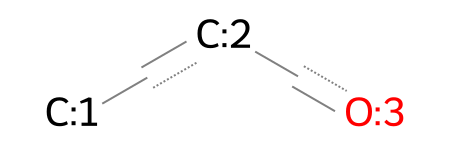

In [4]:
# Template at radius 1
radius = 1 

template = get_template_around_rxn_sites(atom_mapped_substrate_smarts = ethanol_smarts, 
                                         reactive_atom_indices = [2],
                                         radius = radius,
                                         include_stereo = False)

print(f'Extracted template: {template}')
print('')
Chem.MolFromSmarts(template)

In [5]:
ethanol_mol.GetSubstructMatches(Chem.MolFromSmarts(template))

((0, 1, 2),)

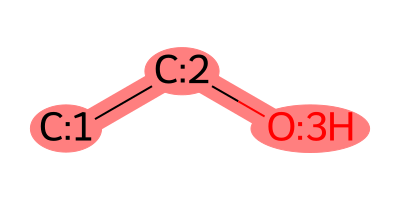

In [6]:
draw.highlight_substructures_in_notebook(substrate_smarts = ethanol_smarts,
                                         substructure_smarts = template)

If we increase the radius to 2 starting from atom C2, however, then we will exceed the ethanol substrate and consequently, not get any template back. An empty string is returned instead:

Extracted template: 



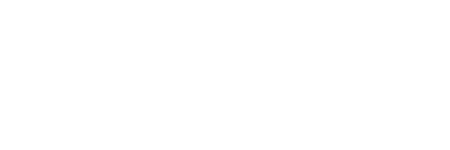

In [7]:
# Template at radius 2
radius = 2 

template = get_template_around_rxn_sites(atom_mapped_substrate_smarts = ethanol_smarts, 
                                         reactive_atom_indices = [2],
                                         radius = radius,
                                         include_stereo = False)

print(f'Extracted template: {template}')
print('')
Chem.MolFromSmarts(template)

#### Templates for mandelonitrile

Switching to mandelonitrile, let's extract reaction templates at increasing radii from 1 through 4. In the nitrilation of mandelonitrile to produce benzyldehyde, the C-C bond between the atoms C2 and C3 is broken to release a nitrile group, while the C-O bond between the atoms C3 and O4 is oxidized to produce a ketone.

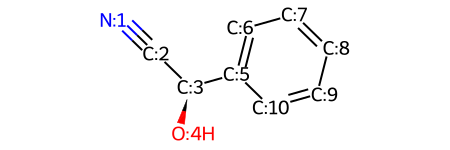

In [9]:
mandelonitrile_mol

Extracted template: [N:1]#[C:2][C@&H1:3]([O&H1:4])[c:5]



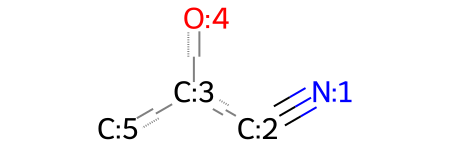

In [10]:
# Template at radius 1

template = get_template_around_rxn_sites(atom_mapped_substrate_smarts = mandelonitrile_smarts,
                                         reactive_atom_indices = [2, 3, 4], 
                                         radius = 1, 
                                         include_stereo = True)
print(f'Extracted template: {template}')
print('')
Chem.MolFromSmarts(template)

In [11]:
mandelonitrile_mol.GetSubstructMatches(Chem.MolFromSmarts(template))

((0, 1, 2, 3, 4),)

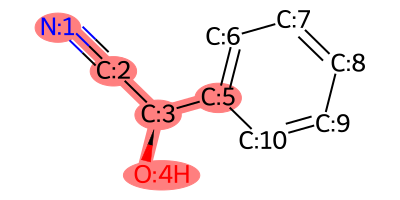

In [12]:
draw.highlight_substructures_in_notebook(substrate_smarts = mandelonitrile_smarts,
                                         substructure_smarts = template)

Extracted template: [N:1]#[C:2][C@&H1:3]([O&H1:4])[c:5]([c&H1:6])[c&H1:10]



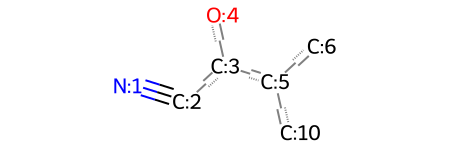

In [13]:
# Template at radius 2

template = get_template_around_rxn_sites(atom_mapped_substrate_smarts = mandelonitrile_smarts,
                                         reactive_atom_indices = [2, 3, 4], 
                                         radius = 2, 
                                         include_stereo = True)
print(f'Extracted template: {template}')
print('')
Chem.MolFromSmarts(template)

In [14]:
mandelonitrile_mol.GetSubstructMatches(Chem.MolFromSmarts(template))

((0, 1, 2, 3, 4, 5, 9),)

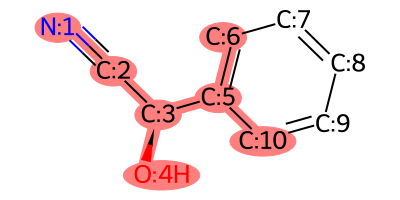

In [15]:
draw.highlight_substructures_in_notebook(substrate_smarts = mandelonitrile_smarts,
                                         substructure_smarts = template)

Extracted template: [N:1]#[C:2][C@&H1:3]([O&H1:4])[c:5]([c&H1:6][c&H1:7])[c&H1:10][c&H1:9]



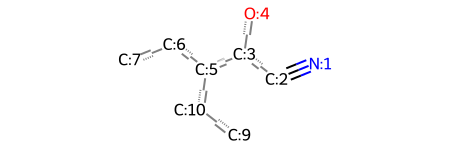

In [16]:
# Template at radius 3

template = get_template_around_rxn_sites(atom_mapped_substrate_smarts = mandelonitrile_smarts,
                                         reactive_atom_indices = [2, 3, 4], 
                                         radius = 3, 
                                         include_stereo = True)
print(f'Extracted template: {template}')
print('')
Chem.MolFromSmarts(template)

In [17]:
mandelonitrile_mol.GetSubstructMatches(Chem.MolFromSmarts(template))

((0, 1, 2, 3, 4, 5, 6, 9, 8),)

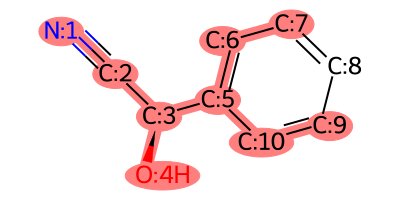

In [18]:
draw.highlight_substructures_in_notebook(substrate_smarts = mandelonitrile_smarts,
                                         substructure_smarts = template)

Extracted template: [N:1]#[C:2][C@&H1:3]([O&H1:4])[c:5]1[c&H1:6][c&H1:7][c&H1:8][c&H1:9][c&H1:10]1



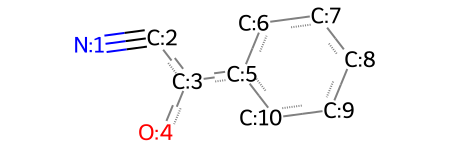

In [19]:
# Template at radius 4

template = get_template_around_rxn_sites(atom_mapped_substrate_smarts = mandelonitrile_smarts,
                                         reactive_atom_indices = [2, 3, 4], 
                                         radius = 4, 
                                         include_stereo = True)
print(f'Extracted template: {template}')
print('')
Chem.MolFromSmarts(template)

In [20]:
mandelonitrile_mol.GetSubstructMatches(Chem.MolFromSmarts(template))

((0, 1, 2, 3, 4, 5, 6, 7, 8, 9),)

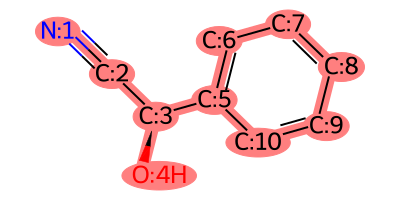

In [21]:
draw.highlight_substructures_in_notebook(substrate_smarts = mandelonitrile_smarts,
                                         substructure_smarts = template)

#### Templates for oxopropanoate

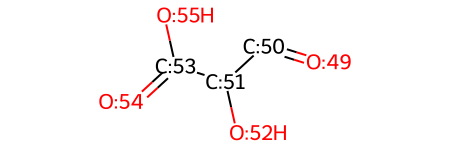

In [22]:
oxopropanoate_mol

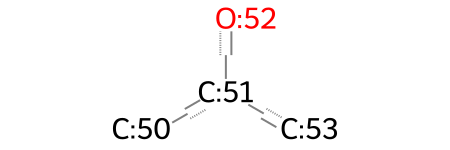

In [23]:
template = get_template_around_rxn_sites(atom_mapped_substrate_smarts = oxopropanoate_smarts,
                                         reactive_atom_indices = [51], 
                                         radius = 1, 
                                         include_stereo = True)

Chem.MolFromSmarts(template)

In [24]:
matches = oxopropanoate_mol.GetSubstructMatches(Chem.MolFromSmarts(template))
matches

((1, 2, 3, 4),)

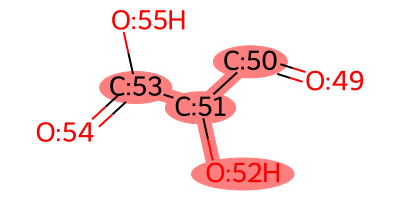

In [25]:
draw.highlight_substructures_in_notebook(substrate_smarts = oxopropanoate_smarts,
                                         substructure_smarts = template)